In [1]:
from collections import defaultdict
import random
import time

from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
from IPython.display import display, Image

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline

In [5]:
from psd_tools import PSDImage, composite, compose

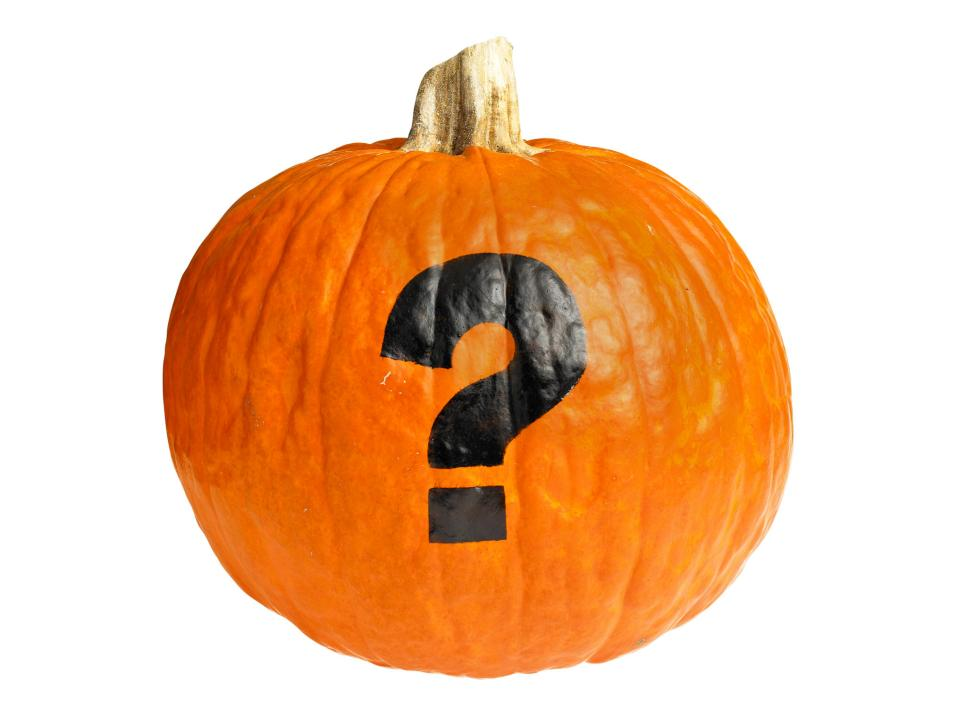

In [3]:
# FIRST, LETS MAKE THE PREREVEAL IMAGE
# ipfs add -r ./pumpkin_collection/prereveal

for i in range(COLLECTION_SIZE):
    with open('mystery_pumpkin.jpeg', 'rb') as src, open(f'./pumpkin_collection/prereveal/{i}.png', 'wb') as dest:
        dest.write(src.read())

display(Image(filename='mystery_pumpkin.jpeg'))

[Group('PUMPKIN' size=834x912), Group('MOUTH'), Group('NOSE'), Group('EYES' size=554x212), Group('Hats')] 


[PixelLayer('3' size=834x912), PixelLayer('0' size=410x224), PixelLayer('1' size=122x164), PixelLayer('4' size=562x130), PixelLayer('0' size=525x525)]


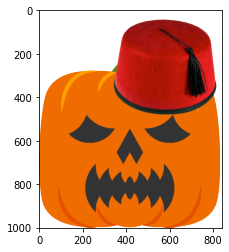

In [10]:
image = PSDImage.open('pumpkin_simple_nft.psd')
print(image._layers, '\n\n')

selection = []
for layer_group in image:
    if layer_group.name == 'Hats':
        if random.random() > 0.7:
            selection.append(random.choice(layer_group))
    else:
        selection.append(random.choice(layer_group))
for layer in selection:
    layer.visible = True

print(selection)

plt.imshow(compose(selection))
plt.show()

In [12]:
COLLECTION_SIZE = 200
RARITY = {'superrare': 0.1, 'rare': 0.2, 'common': .7}
MARGIN_OF_ERROR = 0.1

traits = {
    'PUMPKIN': {
        'optional': False,
        'percent_empty': 0.2,
        'values': [
            {'name': '0', 'rarity': 'rare'},
            {'name': '1', 'rarity': 'superrare'},
            {'name': '2', 'rarity': 'rare'},
            {'name': '3', 'rarity': 'common'},
            {'name': '4', 'rarity': 'common'},
            {'name': '5', 'rarity': 'rare'},
        ],
    },
    'MOUTH': {
        'optional': False,
        'percent_empty': None,
        'values': [
            {'name': '0', 'rarity': 'common'},
            {'name': '1', 'rarity': 'common'},
            {'name': '2', 'rarity': 'rare'},
            {'name': '3', 'rarity': 'rare'},
            {'name': '4', 'rarity': 'rare'},
            {'name': '5', 'rarity': 'superrare'},
        ],
    },
    'NOSE': {
        'optional': False,
        'percent_empty': None,
        'values': [
            {'name': '0', 'rarity': 'common'},
            {'name': '1', 'rarity': 'common'},
            {'name': '2', 'rarity': 'common'},
            {'name': '3', 'rarity': 'common'},
            {'name': '4', 'rarity': 'rare'},
            {'name': '5', 'rarity': 'superrare'},
        ],
    },
    'EYES': {
        'optional': False,
        'percent_empty': 0.2,
        'values': [
            {'name': '0', 'rarity': 'common'},
            {'name': '1', 'rarity': 'common'},
            {'name': '2', 'rarity': 'common'},
            {'name': '3', 'rarity': 'rare'},
            {'name': '4', 'rarity': 'rare'},
            {'name': '5', 'rarity': 'superrare'},
        ],
    },
    'Hats': {
        'optional': True,
        'percent_empty': 0.6,
        'values': [
            {'name': '0', 'rarity': 'rare'},
            {'name': '1', 'rarity': 'superrare'},
            {'name': '2', 'rarity': 'common'},
        ],
    },
}

NEVER_PAIR = [
    ('Hats-0', 'PUMPKIN-5'),
    ('Hats-1', 'PUMPKIN-5'),
    ('Hats-2', 'PUMPKIN-5'),
]

# META_TRAITS = {
#     4: int(COLLECTION_SIZE * .55),
#     5: int(COLLECTION_SIZE * .5),
# }

In [13]:
trait_names = defaultdict(list)
for trait_class in traits:
    for trait in traits[trait_class]['values']:
        trait_names[trait_class].append(trait['name'])

# RARITIES
trait_rarity_collections = defaultdict(lambda: defaultdict(int))
for trait_class in traits:
    for trait in traits[trait_class]['values']:
        trait_rarity_collections[trait_class][trait['rarity']] += 1

model = cp_model.CpModel()

collection = {}
for i in range(COLLECTION_SIZE):
    for trait in traits:
        for j in traits[trait]['values']:
            name = j['name']
            collection[(i, trait, name)] = model.NewBoolVar(f'{trait}-{name}-{i}')

# ENSURE ONLY ONE TRAIT per class
for i in range(COLLECTION_SIZE):
    for trait_class in traits:
        if traits[trait_class]['optional']:
            model.Add(
                sum(collection[(i, trait_class, trait_name)]
                           for trait_name in [trait['name'] for trait in traits[trait_class]['values']]
            ) <= 1)
        else:
            model.Add(
                sum(collection[(i, trait_class, trait_name)]
                           for trait_name in [trait['name'] for trait in traits[trait_class]['values']]
            ) == 1)

# handle rarity
for trait_class in traits:
    if traits[trait_class]['optional']:
        with_trait_class_amount = COLLECTION_SIZE * (1 - traits[trait_class]['percent_empty'])
    else:
        with_trait_class_amount = COLLECTION_SIZE

    for trait in traits[trait_class]['values']:
        trait_name = trait['name']
        rarity_count = trait_rarity_collections[trait_class][trait['rarity']]
        total = int(RARITY[trait['rarity']] * with_trait_class_amount / rarity_count)
        model.Add(
            sum(collection[(i, trait_class, trait_name)]
                       for i in range(COLLECTION_SIZE)
        ) <= int(total * (1 + MARGIN_OF_ERROR)))
        model.Add(
            sum(collection[(i, trait_class, trait_name)]
                       for i in range(COLLECTION_SIZE)
        ) >= int(total * (1 - MARGIN_OF_ERROR)))

# # META-TRAITS
# for i in range(4, 6):
#     trait_array = [model.NewBoolVar(f'{i}_traits_{j}') for i in range(COLLECTION_SIZE)]
#     model.Add(sum(trait_array) == META_TRAITS[i])
#     for user_ix in range(COLLECTION_SIZE):
#         model.Add(
#             sum(collection[(i, trait_class, trait_name)]
#                 for trait_class in traits
#                 for trait_name in trait_names[trait_class]) == i
#         ).OnlyEnforceIf(trait_array[user_ix])

# ensure uniqueness
trait_combinations = []
for i in range(COLLECTION_SIZE):
    total = model.NewIntVar(0, 2 ** 62, f'uniqueness-{i}')
    subl = []
    iteration = 0
    for ix, trait_class in enumerate(traits):
        for iy, trait_name in enumerate(trait_names[trait_class]):
            iteration += 1
            subl.append(collection[(i, trait_class, trait_name)])
    model.Add(total == sum(v * 2 ** i for i, v in enumerate(subl)))
    trait_combinations.append(total)
model.AddAllDifferent(trait_combinations)

# never pair
for pair in NEVER_PAIR:
    for i in range(COLLECTION_SIZE):
        left, right = pair
        ((ll, lr), (rl, rr)) = left.split('-'), right.split('-')
        model.Add(collection[(i, ll, lr)] == False).OnlyEnforceIf(collection[(i, rl, rr)])
        model.Add(collection[(i, rl, rr)] == False).OnlyEnforceIf(collection[(i, ll, lr)])

print('solving')
start = time.time()
solver = cp_model.CpSolver()
print(solver.StatusName(solver.Solve(model)))
print('took: ', time.time() - start)

solving
OPTIMAL
took:  0.7318949699401855


In [14]:
def get_traits_for_index(traits, collection, solver, ix):
    ans = []
    for trait_class in traits:
        for ij, trait in enumerate(traits[trait_class]['values']):
            trait_name = traits[trait_class]['values'][ij]['name']
            if solver.Value(collection[(ix, trait_class, trait_name)]):
                ans.append((trait_class, trait_name))
    return ans

In [16]:
output = {}

for i in range(COLLECTION_SIZE):
    output[i] = get_traits_for_index(traits, collection, solver, i)

In [17]:
def make_pumpkin(selected_traits):
    image = PSDImage.open('simplified_jackolantern.psd')
    selections = []
    for selected_trait in selected_traits:
        trait, index = selected_trait
        for group in image:
            if trait in group.name:
                selected_group = group
                break
        selected_layer = selected_group[int(index)]
        selected_layer.visible = True
        selections.append(selected_layer)
    return selections

In [18]:
for i in range(COLLECTION_SIZE):
    print(i)
    my_pumpkin = compose(make_pumpkin(output[i]))
    my_pumpkin.save(f'./pumpkin_collection/reveal/{i}.png')

In [19]:
# # already uploaded to IPFS
# # this is my hash QmYuYQsm75UKenAdEec31d5SCEMZrR4oqrFrSX3qekDYha

PREREVEAL_IPFS_IMAGE_HASH = 'QmYuYQsm75UKenAdEec31d5SCEMZrR4oqrFrSX3qekDYha'
REVEAL_IPFS_IMAGE_HASH = 'QmPkTf4UkMaWNc4drDFJAa4anPjHqYoZgQR7KB44Fx8S7P'

In [20]:
# MAKE JSON
import json

def make_json(ix, prereveal=True):
    traits = output[ix]
    if prereveal:
        image_url = f'https://ipfs.io/ipfs/{PREREVEAL_IPFS_IMAGE_HASH}/{ix}.png'
        return {
            'name': f'Pumpkin #{i}',
            'description': 'Some fun pumpkin NFTs',
            'image': image_url,
            'attributes': [
                {'trait_type': 'status', 'value': 'hidden'}
            ]
        }
    else:
        image_url = f'https://ipfs.io/ipfs/{REVEAL_IPFS_IMAGE_HASH}/{ix}.png'
        return {
            'name': f'Pumpkin #{i}',
            'description': 'Some fun pumpkin NFTs',
            'image': image_url,
            'attributes': [
                {'trait_type': i, 'value': ix} for (i, ix) in traits
            ]
        }


for i in range(COLLECTION_SIZE):
    with open(f'./pumpkin_collection/prereveal/json/{i}.json', 'w') as f:
        f.write(json.dumps(make_json(i, True)))
    with open(f'./pumpkin_collection/reveal/json/{i}.json', 'w') as f:
        f.write(json.dumps(make_json(i, False)))